In [5]:
import os
import pickle
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any, Optional
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from prophet import Prophet
from llms import llama,llamaScout,mistral
from datetime import datetime, timedelta 
import requests
from bs4 import BeautifulSoup
from pydantic import BaseModel, Field
from typing import Literal
import json



# Initialize search tool
ddg_search = DuckDuckGoSearchRun(description="Fetches the current and latest cardamom prices from the web",name="DuckDuckGo")

# Define the state
class AgentState(Dict):
    """State for the cardamom agent graph."""
    messages: List[Dict]
    next_agent: Optional[str] = None
    prediction_data: Optional[pd.DataFrame] = None
    search_results: Optional[str] = None
    conversation_history: Optional[List[Dict]] = None  # Saving messages in momory memory

# Date handling functions
def parse_relative_date(date_text: str) -> datetime:
    """
    Converts relative date references like 'today', 'tomorrow', 'next week' to actual dates.
    
    Args:
        date_text: A string containing a relative date reference
        
    Returns:
        A datetime object representing the actual date
    """
    today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    
    # Dictionary of common relative date terms and their timedelta values
    relative_dates = {
        "today": timedelta(days=0),
        "tomorrow": timedelta(days=1),
        "day after tomorrow": timedelta(days=2),
        "yesterday": timedelta(days=-1),
        "next week": timedelta(weeks=1),
        "last week": timedelta(weeks=-1),
        "next month": timedelta(days=30),  # Approximation
        "last month": timedelta(days=-30),  # Approximation
        "next year": timedelta(days=365),  # Approximation
        "last year": timedelta(days=-365),  # Approximation
    }
    
    # Handle special cases with specific day names
    weekdays = {
        "monday": 0, "tuesday": 1, "wednesday": 2, "thursday": 3,
        "friday": 4, "saturday": 5, "sunday": 6
    }
    
    date_text = date_text.lower().strip()
    
    # Direct matches from our dictionary
    if date_text in relative_dates:
        return today + relative_dates[date_text]
    
    # Handle "next [weekday]" or "[weekday]"
    for day, day_num in weekdays.items():
        if f"next {day}" in date_text:
            days_ahead = day_num - today.weekday()
            if days_ahead <= 0:  # Target day already happened this week
                days_ahead += 7
            return today + timedelta(days=days_ahead)
        
        if date_text == day:
            days_ahead = day_num - today.weekday()
            if days_ahead <= 0:  # Target day already happened this week
                days_ahead += 7
            return today + timedelta(days=days_ahead)
    
    # Handle "in X days/weeks/months/years"
    if "in" in date_text:
        parts = date_text.split()
        try:
            if len(parts) >= 3:
                number = int(parts[1])
                unit = parts[2].lower()
                
                if unit.startswith("day"):
                    return today + timedelta(days=number)
                elif unit.startswith("week"):
                    return today + timedelta(weeks=number)
                elif unit.startswith("month"):
                    return today + timedelta(days=number*30)  # Approximation
                elif unit.startswith("year"):
                    return today + timedelta(days=number*365)  # Approximation
        except (ValueError, IndexError):
            pass
    
    # Handle "X days/weeks/months/years from now"
    if "from now" in date_text:
        parts = date_text.split()
        try:
            if len(parts) >= 4:
                number = int(parts[0])
                unit = parts[1].lower()
                
                if unit.startswith("day"):
                    return today + timedelta(days=number)
                elif unit.startswith("week"):
                    return today + timedelta(weeks=number)
                elif unit.startswith("month"):
                    return today + timedelta(days=number*30)  # Approximation
                elif unit.startswith("year"):
                    return today + timedelta(days=number*365)  # Approximation
        except (ValueError, IndexError):
            pass
    
    # Handle "X days/weeks/months/years ago"
    if "ago" in date_text:
        parts = date_text.split()
        try:
            if len(parts) >= 3:
                number = int(parts[0])
                unit = parts[1].lower()
                
                if unit.startswith("day"):
                    return today - timedelta(days=number)
                elif unit.startswith("week"):
                    return today - timedelta(weeks=number)
                elif unit.startswith("month"):
                    return today - timedelta(days=number*30)  # Approximation
                elif unit.startswith("year"):
                    return today - timedelta(days=number*365)  # Approximation
        except (ValueError, IndexError):
            pass
    
    # Default to today if we can't parse the date
    # In a production system, you might want to raise an exception instead
    return today

def extract_date_from_query(query: str) -> Tuple[str, Optional[datetime]]:
    """
    Extracts date information from a user query.
    
    Args:
        query: The user's query text
        
    Returns:
        A tuple of (date_type, date_value) where:
        - date_type is 'specific', 'relative', 'range', or 'none'
        - date_value is a datetime object or None
    """
    # Using Mistral for date extraction as it might be good at pattern recognition
    date_extraction = mistral.invoke([
        HumanMessage(content=f"""
        Extract the date information from this query: "{query}"
        
        Analyze the query for:
        1. Specific dates (e.g., "April 30, 2025")
        2. Relative dates (e.g., "tomorrow", "next week", "in 3 days")
        3. Date ranges (e.g., "next month", "next 30 days")
        
        Return your answer in this format:
        DATE_TYPE: specific/relative/range/none
        DATE_TEXT: the exact text that refers to the date
        
        Examples:
        For "What will cardamom prices be on May 15th?" return:
        DATE_TYPE: specific
        DATE_TEXT: May 15th
        
        For "How much will cardamom cost tomorrow?" return:
        DATE_TYPE: relative
        DATE_TEXT: tomorrow
        
        For "Predict cardamom prices for the next two weeks" return:
        DATE_TYPE: range
        DATE_TEXT: next two weeks
        
        For "Tell me about cardamom diseases" return:
        DATE_TYPE: none
        DATE_TEXT: 
        """)
    ])
    
    # Parse the LLM response
    response_lines = date_extraction.content.strip().split('\n')
    date_type = "none"
    date_text = ""
    
    for line in response_lines:
        if line.startswith("DATE_TYPE:"):
            date_type = line.split(":", 1)[1].strip().lower()
        elif line.startswith("DATE_TEXT:"):
            date_text = line.split(":", 1)[1].strip()
    
    # Process based on date type
    if date_type == "specific":
        try:
            # Try to parse as a specific date
            date_value = pd.to_datetime(date_text)
            return "specific", date_value
        except:
            # If parsing fails, fall back to today
            return "specific", datetime.now()
    
    elif date_type == "relative":
        # Parse relative date references
        date_value = parse_relative_date(date_text)
        return "relative", date_value
    
    elif date_type == "range":
        # For ranges return the start date
        return "range", None
    
    else:
        # No date mentioned
        return "none", None

# Load the Prophet model predictions
def load_predictions():
    """
    Loads the prediction from the saved Prophet modle for 90 days
    """
    with open('prophet_cardamom_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)


    # Step 2: Create future dates for prediction
    future_dates = loaded_model.make_future_dataframe(periods=90)
    forecast = loaded_model.predict(future_dates)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)



class routes(BaseModel):
    agent : Literal['PREDICTION', 'INFO', 'PRICE_FETCH', 'HISTORICAL_PRICE', 'GREETING', 'CAPABILITY', 'OFF_TOPIC'] = Field(...,description="""
        - PREDICTION: If the query is about cardamom price predictions or forecasts
        - INFO: If the query is seeking information about cardamom (cultivation, diseases, etc.)
        - PRICE_FETCH: If the query is about current market prices of cardamom
        - HISTORICAL_PRICE: If the query is about past/historical cardamom prices
        - GREETING: If the query is a greeting (hello, hi, etc.) or asks who the agent is
        - CAPABILITY: If the query asks what the agent can do or how it can help
        - OFF_TOPIC: If the query is not related to cardamom""")

# Agent Functions
#router initial 
def router(state: AgentState) -> Dict:
    """
    Routes to the appropriate agent based on the query type using AI classification.
    """
    messages = state["messages"]
    last_message = messages[-1]["content"]
    
    # Using LlamaScout for comprehensive routing
    llm_response = llamaScout.invoke([
        HumanMessage(content=f"""
        Analyze the following user query and determine which specialized agent should handle it:
        
        Query: {last_message}
        
        Respond with exactly one of these options:
        - GREETING: If the query is a greeting (hello, hi, etc.) or asks who the agent is
        - CAPABILITY: If the query asks what the agent can do or how it can help
        - PREDICTION: If the query is about cardamom price predictions or forecasts
        - INFO: If the query is seeking information about cardamom (cultivation, diseases, etc.)
        - PRICE_FETCH: If the query is about current market prices of cardamom
        - HISTORICAL_PRICE: If the query is about past/historical cardamom prices
        - OFF_TOPIC: If the query is not related to cardamom
        
        Just return the option name, nothing else.
        """)
    ])
    
    agent_type = llm_response.content.strip()
    
    agent_mapping = {
        "GREETING": "greeting_agent",
        "CAPABILITY": "capability_agent",
        "PREDICTION": "prediction_agent",
        "INFO": "info_agent",
        "PRICE_FETCH": "price_fetch_agent",
        "HISTORICAL_PRICE": "historical_price_agent",
        "OFF_TOPIC": "off_topic_agent"
    }
    
    next_agent = agent_mapping.get(agent_type, "off_topic_agent")
    return {"next_agent": next_agent}

def prediction_agent(state: AgentState) -> Dict:
    """
    Handles queries about price predictions.
    """
    messages = state["messages"]
    last_message = messages[-1]["content"]
    
    # Load predictions if not already loaded
    if state.get("prediction_data") is None:
        state["prediction_data"] = load_predictions()
    
    predictions_df = state["prediction_data"]
    
    # Check if predictions data is empty
    if predictions_df.empty:
        response = llama.invoke([
            HumanMessage(content="""Just Tell the user politely that you couldnt make the predictions,
                          as something went wrong internally and that to try again later and nothing else. Give the message string
                                """)
        ])
        return {"messages": messages + [{"role": "assistant", "content": response.content}]}
    
    # Extract date from user query using our date function
    date_type, date_value = extract_date_from_query(last_message)
    
    # Get the range limits for predictions
    min_date = predictions_df['ds'].min()
    max_date = predictions_df['ds'].max()
    
    if date_type == "range":
        # Using Llama for generating prediction summaries as it has good comprehension
        response = llama.invoke([
            HumanMessage(content=f"""
            The user is asking about cardamom price predictions across a range of dates.
            Here's the first few rows of our predictions:
            
            {predictions_df.head(5).to_string()}
            
            And here's the last few rows of our predictions:
            {predictions_df.tail(5).to_string()}
            
            Generate a helpful summary of the prediction trends over the 90-day period.
            Include the date range, average price, minimum and maximum predicted prices.
            """)
        ])
        return {"messages": messages + [{"role": "assistant", "content": response.content}]}
    
    elif date_type == "none":
        # If no date specified, use the latest prediction
        try:
            # Get the first row (most recent date)
            prediction_row = predictions_df.iloc[0]
            date = prediction_row['ds'].strftime('%Y-%m-%d')
            prediction = float(prediction_row['yhat'])
            lower = float(prediction_row['yhat_lower'])
            upper = float(prediction_row['yhat_upper'])
        except (IndexError, KeyError) as e:
            response = llama.invoke([
                HumanMessage(content=f"""Just Tell the user politely that you couldnt make the predictions, 
                             as something went wrong internally and that to try again later and nothing else.
                              Give the message string""")
            ])
            return {"messages": messages + [{"role": "assistant", "content": response.content}]}
    
    elif date_type in ["specific", "relative"]:
        # For specific or relative dates, check if the date is beyond 90 days
        if date_value:
            try:
                # Convert date_value to timestamp for comparison
                target_date = pd.Timestamp(date_value)
                
                # Check if the target date is beyond our 90-day prediction window
                if target_date > max_date:
                    # Get the latest price from predictions_df (first row)
                    latest_row = predictions_df.iloc[0]
                    latest_date = latest_row['ds'].strftime('%Y-%m-%d')
                    latest_prediction = float(latest_row['yhat'])
                    
                    # Get the furthest prediction (90th day)
                    furthest_row = predictions_df.iloc[-1]
                    furthest_date = furthest_row['ds'].strftime('%Y-%m-%d')
                    furthest_prediction = float(furthest_row['yhat'])
                    
                    response = llama.invoke([
                        HumanMessage(content=f"""
                        The user asked for a prediction on {target_date.strftime('%Y-%m-%d')}, which is beyond our 90-day prediction window.
                        
                        Please explain that we can only provide predictions up to {max_date.strftime('%Y-%m-%d')}.
                        
                        Include the following information:
                        - Latest available price: ₹{latest_prediction:.2f} on {latest_date}
                        - Our furthest prediction: ₹{furthest_prediction:.2f} on {furthest_date}
                        
                        Make the response conversational and helpful, suggesting they ask about dates within our prediction window.
                        """)
                    ])
                    return {"messages": messages + [{"role": "assistant", "content": response.content}]}
                
                # Create a new column with the difference between each date and the target date
                predictions_df['date_diff'] = abs((predictions_df['ds'] - target_date).dt.total_seconds())
                
                # Find the row with the minimum difference
                closest_row = predictions_df.loc[predictions_df['date_diff'].idxmin()]
                
                date = closest_row['ds'].strftime('%Y-%m-%d')
                prediction = float(closest_row['yhat'])
                lower = float(closest_row['yhat_lower'])
                upper = float(closest_row['yhat_upper'])
                
                # Remove the temporary column
                predictions_df.drop('date_diff', axis=1, inplace=True)
                
            except Exception as e:
                response = llama.invoke([
                    HumanMessage(content=f"""
                    I couldn't find a prediction for the date: {date_value.strftime('%Y-%m-%d') if hasattr(date_value, 'strftime') else str(date_value)}
                    
                    Our predictions range from {predictions_df['ds'].min().strftime('%Y-%m-%d')} to {predictions_df['ds'].max().strftime('%Y-%m-%d')}.
                    Please try a date within this range.
                    
                    Technical details: {str(e)}
                    """)
                ])
                return {"messages": messages + [{"role": "assistant", "content": response.content}]}
        else:
            # Fallback if date parsing failed
            response = llama.invoke([
                HumanMessage(content=f"""
                I couldn't identify a specific date in the query: "{last_message}"
                
                Please provide a friendly response asking for clarification on which date they want a prediction for.
                Mention that we have predictions available from {predictions_df['ds'].min().strftime('%Y-%m-%d')} to {predictions_df['ds'].max().strftime('%Y-%m-%d')}.
                """)
            ])
            return {"messages": messages + [{"role": "assistant", "content": response.content}]}
    
    try:
        response = llama.invoke([
            HumanMessage(content=f"""
            Create a friendly, helpful response about the cardamom price prediction for {date}.
            
            Here's the data:
            - Predicted price: ₹{prediction:.2f}
            - Lower bound: ₹{lower:.2f}
            - Upper bound: ₹{upper:.2f}
            
            Make the response conversational and easy to understand for someone in the cardamom industry.
            """)
        ])
    except Exception as e:
        response = llama.invoke([
            HumanMessage(content=f"I encountered an error while generating the prediction response: {str(e)}")
        ])
    
    return {"messages": messages + [{"role": "assistant", "content": response.content}]}


def historical_price_agent(state: AgentState) -> Dict:
    """
    Handles queries about historical cardamom prices.
    """
    messages = state["messages"]
    last_message = messages[-1]["content"]
    
    # Extract date information to focus the search
    date_type, date_value = extract_date_from_query(last_message)
    
    # Formulate a search query based on the date information
    if date_type == "none":
        search_query = "historical cardamom prices trends data"
    elif date_type == "range":
        search_query = f"historical cardamom prices {last_message}"
    else:
        # For specific or relative dates
        if date_value:
            date_str = date_value.strftime('%B %Y')  # Format as "Month Year"
            search_query = f"cardamom prices on {date_str} historical data"
        else:
            search_query = "historical cardamom prices trends data"
    
    # Use DDG search to get historical price information
    search_results = ddg_search.invoke(search_query)
    
    # Process search results with Llama
    response = llama.invoke([
        HumanMessage(content=f"""
        The user asked about historical cardamom prices: "{last_message}"
        
        Here are search results that might contain historical price information:
        {search_results}
        
        Extract and summarize the most relevant historical cardamom price information.
        Include:
        1. Price ranges during the requested period if available
        2. Historical trends and patterns
        3. Factors that affected prices during that period
        4. Any notable price fluctuations or stability
        
        Format this as a helpful historical market report. If you can't find specific 
        historical data for the exact period requested, mention that and provide 
        the closest available historical information.
        """)
    ])
    
    return {"messages": messages + [{"role": "assistant", "content": response.content}]}

def info_agent(state: AgentState) -> Dict:
    """
    Handles queries about cardamom information.
    """
    messages = state["messages"]
    last_message = messages[-1]["content"]
    
    # Use DDG search to get information
    search_query = f"cardamom {last_message}"
    search_results = ddg_search.invoke(search_query)
    
    # Process search results with Llama which is good for factual information
    response = llama.invoke([
        HumanMessage(content=f"""
        The user asked: "{last_message}"
        
        Here are search results about cardamom related to their query:
        {search_results}
        
        Please provide a helpful, accurate response about cardamom based on this information.
        Focus specifically on answering their question with relevant details. 
        If the search results don't provide good information, offer general knowledge about cardamom
        cultivation, varieties, diseases, or processing as relevant to their query.
        """)
    ])
    
    return {"messages": messages + [{"role": "assistant", "content": response.content}]}

def general_agent(state: AgentState):
    """
    You are a cardamom expert and will ac
    """

def spiceboard_prices():
    """
    Extracts historic cardamom prices.
    
    Args:
        date: str : Date in DD-MM-YYYY format or None for latest.
                    Note: This function scrapes the *current* daily price page,
                    which usually shows the latest few days. The date parameter
                    is not used for filtering the scraped data, only the latest
                    available data on the page is returned regardless of the date input.
    """
    url = "https://www.indianspices.com/marketing/price/domestic/daily-price.html"
    
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        soup = BeautifulSoup(response.text, 'html.parser')
        
        price_data = []
        
        # Find tables potentially containing cardamom prices
        tables = soup.find_all('table')
        
        for table in tables:
            rows = table.find_all('tr')
            if not rows: continue

            # Find the header row by looking for price-related text and common column headers
            header_row = None
            header_indices = {}
            for r in rows:
                headers_text = " ".join([cell.text.strip() for cell in r.find_all(['th', 'td'])]).lower()
                # Look for table headers that seem to indicate price data and relevant columns
                # Check for common header patterns seen in the source HTML
                if ('price' in headers_text and any(col_name in headers_text for col_name in ['date', 'auctioneer', 'market'])) or \
                   ('avg.price (rs./kg)' in headers_text and 'maxprice (rs./kg)' in headers_text): # More specific check for small cardamom table
                    header_row = r
                    headers = [cell.text.strip() for cell in header_row.find_all(['th', 'td'])]
                    # Create a dictionary mapping header text to column index
                    # Handle duplicate headers by taking the first occurrence
                    header_indices = {}
                    for i, header in enumerate(headers):
                         # Normalize header text by stripping whitespace and removing unusual characters if necessary
                         clean_header = header.strip().replace('\n', ' ').replace('\r', '').strip()
                         if clean_header and clean_header not in header_indices:
                             header_indices[clean_header] = i
                    break # Found a potential header row, exit inner loop

            if header_row and header_indices:
                # Determine table type based on specific price headers
                is_small_cardamom_table = 'Avg.Price (Rs./Kg)' in header_indices and 'MaxPrice (Rs./Kg)' in header_indices
                is_large_cardamom_table = 'Price (Rs./Kg)' in header_indices and not is_small_cardamom_table # General Price col usually indicates Large Cardamom if Avg/Max are missing
                
                if not is_small_cardamom_table and not is_large_cardamom_table:
                     # Skip tables that don't match expected cardamom price structures
                     continue

                # Process data rows (skip header and any other non-data rows before it)
                try:
                    data_rows = rows[rows.index(header_row) + 1:]
                except ValueError:
                     continue

                for row in data_rows:
                    cols = row.find_all('td')
                    if not cols: continue # Skip empty rows or rows with only th
                    
                    # Basic check to ensure row looks like data (e.g., starts with a number or a date-like string)
                    if not cols[0].text.strip().isdigit() and not any(d.isdigit() for d in cols[0].text.strip()):
                         continue # Skip rows that don't start with number (Sno) or date

                    entry = {'source': 'Spice Board of India'}
                    
                    try:
                        # Extract common data based on potential header keys
                        date_key = 'Date of Auction' if 'Date of Auction' in header_indices else 'Date'
                        if date_key in header_indices and len(cols) > header_indices[date_key]:
                            entry['date'] = cols[header_indices[date_key]].text.strip()

                        market_key = 'Auctioneer' if 'Auctioneer' in header_indices else 'Market'
                        if market_key in header_indices and len(cols) > header_indices[market_key]:
                            entry['market_or_auctioneer'] = cols[header_indices[market_key]].text.strip()

                        # Extract price(s) and quantities based on table type
                        if is_small_cardamom_table:
                            entry['variety'] = 'Small Cardamom'
                            if 'MaxPrice (Rs./Kg)' in header_indices and len(cols) > header_indices['MaxPrice (Rs./Kg)']:
                                entry['max_price_rs_kg'] = float(cols[header_indices['MaxPrice (Rs./Kg)']].text.strip().replace(',', ''))
                            if 'Avg.Price (Rs./Kg)' in header_indices and len(cols) > header_indices['Avg.Price (Rs./Kg)']:
                                entry['avg_price_rs_kg'] = float(cols[header_indices['Avg.Price (Rs./Kg)']].text.strip().replace(',', ''))
                            if 'Total Qty Arrived (Kgs)' in header_indices and len(cols) > header_indices['Total Qty Arrived (Kgs)']:
                                entry['quantity_arrived_kgs'] = float(cols[header_indices['Total Qty Arrived (Kgs)']].text.strip().replace(',', ''))
                            if 'Qty Sold (Kgs)' in header_indices and len(cols) > header_indices['Qty Sold (Kgs)']:
                                entry['quantity_sold_kgs'] = float(cols[header_indices['Qty Sold (Kgs)']].text.strip().replace(',', ''))

                        elif is_large_cardamom_table:
                            entry['variety'] = 'Large Cardamom'
                            if 'Price (Rs./Kg)' in header_indices and len(cols) > header_indices['Price (Rs./Kg)']:
                                entry['price_rs_kg'] = float(cols[header_indices['Price (Rs./Kg)']].text.strip().replace(',', ''))
                            if 'Type' in header_indices and len(cols) > header_indices['Type']:
                                entry['type'] = cols[header_indices['Type']].text.strip()
                            

                        # Add entry only if it has a date and at least one price field
                        if entry.get('date') and (entry.get('avg_price_rs_kg') is not None or entry.get('price_rs_kg') is not None):
                             price_data.append(entry)
                      

                    except (ValueError, IndexError, KeyError) as e:
                        pass # Skip rows with errors

        if not price_data:
             return "Could not find relevant cardamom price data on the Spice Board website tables."
        
        # Format the output string for the agent, clearly listing the data found
        formatted_output = "Scraped Spice Board Prices (Latest Available):\n"
        for entry in price_data:
             formatted_output += f"- Date: {entry.get('date', 'N/A')}, Variety: {entry.get('variety', 'N/A')}\n"
             formatted_output += f"  Market/Auctioneer: {entry.get('market_or_auctioneer', 'N/A')}\n"
             if 'type' in entry: formatted_output += f"  Type: {entry['type']}\n"
             if 'avg_price_rs_kg' in entry: formatted_output += f"  Avg. Price (Rs./Kg): {entry['avg_price_rs_kg']}\n"
             if 'max_price_rs_kg' in entry: formatted_output += f"  Max Price (Rs./Kg): {entry['max_price_rs_kg']}\n"
             if 'price_rs_kg' in entry: formatted_output += f"  Price (Rs./Kg): {entry['price_rs_kg']}\n"
             if 'quantity_arrived_kgs' in entry: formatted_output += f"  Qty Arrived (Kgs): {entry['quantity_arrived_kgs']}\n"
             if 'quantity_sold_kgs' in entry: formatted_output += f"  Qty Sold (Kgs): {entry['quantity_sold_kgs']}\n"
             formatted_output += "---\n"

        return formatted_output
    except BaseException as e:
        return { 'error' : e }

def price_fetch_agent(state: AgentState) -> Dict:
    """
    Fetches current cardamom prices from the spice board website.
    """
    messages = state["messages"]
    last_message = messages[-1]["content"]
    
    # Use DDG search to get current prices
    search_results = ddg_search.invoke("current and latest cardamom price today in India")
    spiceboard_prices_results = spiceboard_prices()
    # Using Mistral for price analysis as it might be good at extracting structured data
    response = mistral.invoke([
        HumanMessage(content=f"""
        The user asked about current cardamom prices: "{last_message}"
        
        Here are search results that might contain current price information:
        {search_results}
        Additionally here are the prices from the official spice board website:
        {spiceboard_prices_results}
        
        Extract and summarize the most recent and relevant cardamom price information.
        Include:
        1. Current price ranges in different markets if available
        2. Any recent trends (increasing/decreasing)
        3. Factors affecting current prices
        
        Format this as a helpful market report. If precise current prices aren't available,
        mention that and provide the most recent information available.
        """)
    ])
    
    return {"messages": messages + [{"role": "assistant", "content": response.content}]}

def off_topic_agent(state: AgentState) -> Dict:
    """
    Handles off-topic queries.
    """
    messages = state["messages"]
    
    polite_response = "I'm sorry, I cannot help you with that. I can only answer queries regarding cardamom, including price predictions, cultivation information, diseases, or market prices. Please feel free to ask me anything about cardamom!"
    
    return {"messages": messages + [{"role": "assistant", "content": polite_response}]}


#Greeting s agent to greet the user or onboard
def greeting_agent(state: AgentState) -> Dict:
    """
    Handles greetings and introduces itself as CardamomCare.
    """
    messages = state["messages"]
    
    introduction = """Hello! I'm CardamomCare, your cardamom industry assistant. I can help you with:

1. Cardamom price predictions
2. Current market prices
3. Historical price trends
4. Information about cardamom cultivation, diseases, and varieties

How can I assist you with your cardamom-related questions today?"""
    
    return {"messages": messages + [{"role": "assistant", "content": introduction}]}


#Gives the capability of the agent
def capability_agent(state: AgentState) -> Dict:
    """
    Explains what CardamomCare can do.
    """
    messages = state["messages"]
    
    capabilities = """As CardamomCare, I'm specialized in all things cardamom and can help you with:

1. **Price Predictions**: I can forecast cardamom prices for specific dates up to 90 days in the future using advanced modeling.

2. **Current Market Prices**: I can provide you with the latest cardamom market prices from the Spice Board of India and other sources.

3. **Historical Price Analysis**: I can show you historical price trends and patterns to help inform your decisions.

4. **Cardamom Information**: I can provide details about:
   - Different cardamom varieties
   - Cultivation techniques
   - Disease management
   - Harvesting best practices
   - Processing methods
   - Market insights

Whether you're a cardamom farmer, trader, or industry professional, I'm here to provide you with valuable information to support your cardamom-related activities. How can I assist you today?"""
    
    return {"messages": messages + [{"role": "assistant", "content": capabilities}]}

# Build the graph
def build_cardamom_agent_graph():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("router", router)
    workflow.add_node("prediction_agent", prediction_agent)
    workflow.add_node("info_agent", info_agent)
    workflow.add_node("price_fetch_agent", price_fetch_agent)
    workflow.add_node("historical_price_agent", historical_price_agent)
    workflow.add_node("greeting_agent", greeting_agent)
    workflow.add_node("capability_agent", capability_agent)  # New node
    workflow.add_node("off_topic_agent", off_topic_agent)
    
    # Add conditional edges from router to appropriate agents
    workflow.add_conditional_edges(
        "router",
        lambda x: x["next_agent"],
        {
            "prediction_agent": "prediction_agent", 
            "info_agent": "info_agent",
            "price_fetch_agent": "price_fetch_agent",
            "historical_price_agent": "historical_price_agent",
            "greeting_agent": "greeting_agent",
            "capability_agent": "capability_agent",  
            "off_topic_agent": "off_topic_agent"
        }
    )
    
    # Connect all agent nodes to END
    workflow.add_edge("prediction_agent", END)
    workflow.add_edge("info_agent", END)
    workflow.add_edge("price_fetch_agent", END)
    workflow.add_edge("historical_price_agent", END)
    workflow.add_edge("greeting_agent", END)
    workflow.add_edge("capability_agent", END)  
    workflow.add_edge("off_topic_agent", END)
    
    # Set the entrypoint
    workflow.set_entry_point("router")
    
    return workflow.compile()

# Create app instance
cardamom_agent = build_cardamom_agent_graph()

#run the cardamom agent
def run_cardamom_agent(query: str, conversation_history: List[Dict] = None):
    """Run the cardamom agent with a query and maintain conversation history."""
    if conversation_history is None:
        conversation_history = []
    
    # Add the new query to the history
    conversation_history.append({"role": "human", "content": query})
    
    # Create state with full conversation history
    state = {
        "messages": [{"role": "human", "content": query}],
        "conversation_history": conversation_history
    }
    
    # Invoke agent
    result = cardamom_agent.invoke(state)
    
    # Add the response to the conversation history
    conversation_history.append({"role": "assistant", "content": result["messages"][-1]["content"]})
    
    # Return the response and updated history
    return result["messages"][-1]["content"], conversation_history

if __name__ == "__main__":
    # Example queries to test
    queries = [
       "wat was the trend last week" ,
    ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        response = run_cardamom_agent(query)
        
        # Unpack response
        response_text, message_history = response

        # Prepare JSON structure
        response_json = {
            "response_text": response_text,
            "messages": message_history
        }

        # Print nicely formatted JSON
        print(json.dumps(response_json["response_text"], indent=4))



Query: wat was the trend last week
"**Historical Cardamom Price Report (Last Week)**\n\nBased on the available data, we have extracted the most relevant historical cardamom price information for the last week (24-30 April 2025). Please note that the exact price trend for the entire week is not available, but we have compiled the closest available data to provide an overview of the market.\n\n**Price Ranges:**\n\n* The average price of 1kg small cardamom as of 28 April 2025 was Rs 2,300.91.\n* The maximum price of 1kg large cardamom as of 24 April 2025 was Rs 1,707.00.\n* Cardamom mandi rates in Kerala ranged from Rs 3,000 to Rs 3,120 per kg during the last week, with a highest recorded price of Rs 3,120 on 29-30 April 2025.\n\n**Historical Trends and Patterns:**\n\n* The data suggests a relatively stable price trend for cardamom during the last week, with minor fluctuations.\n* The average price of small cardamom increased by approximately Rs 300-400 per kg compared to the previous we

In [6]:
def build_cardamom_agent_graph():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("router", router)
    workflow.add_node("prediction_agent", prediction_agent)
    workflow.add_node("info_agent", info_agent)
    workflow.add_node("price_fetch_agent", price_fetch_agent)
    workflow.add_node("historical_price_agent", historical_price_agent)
    workflow.add_node("greeting_agent", greeting_agent)
    workflow.add_node("capability_agent", capability_agent)  # New node
    workflow.add_node("off_topic_agent", off_topic_agent)
    
    # Add conditional edges from router to appropriate agents
    workflow.add_conditional_edges(
        "router",
        lambda x: x["next_agent"],
        {
            "prediction_agent": "prediction_agent", 
            "info_agent": "info_agent",
            "price_fetch_agent": "price_fetch_agent",
            "historical_price_agent": "historical_price_agent",
            "greeting_agent": "greeting_agent",
            "capability_agent": "capability_agent",  
            "off_topic_agent": "off_topic_agent"
        }
    )
    
    # Connect all agent nodes to END
    workflow.add_edge("prediction_agent", END)
    workflow.add_edge("info_agent", END)
    workflow.add_edge("price_fetch_agent", END)
    workflow.add_edge("historical_price_agent", END)
    workflow.add_edge("greeting_agent", END)
    workflow.add_edge("capability_agent", END)  
    workflow.add_edge("off_topic_agent", END)
    
    # Set the entrypoint
    workflow.set_entry_point("router")
    
    return workflow.compile()

In [8]:
%pip install grandalf

     -------------------------------------- 41.8/41.8 kB 112.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


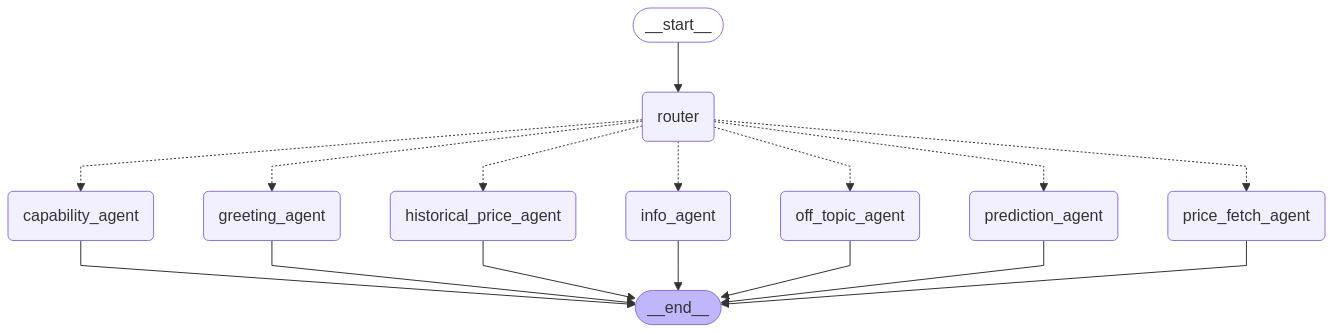

In [7]:
from IPython.display import Image
graph =  build_cardamom_agent_graph()
Image(graph.get_graph().draw_mermaid_png())